# 최적화 설계

## 최적화
- 운송최적화, 생산최적화 등
- 정해진 제약 조건 하에서 목적함수를 최소화 (또는 최대화) 하는 것
### 예시
- 철도 운행 최적화, 수요 반응, 에너지 공급, 엘리베이터 제어, 인원 스케줄링, 상품 진열, 재고 관리, 도시 계획, 로트 사이즈 결정, 가격 결정 등
### 방법
- 선형 최적화 (요소들이 선형관계일 때, 매트릭스 연산): 심플렉스 법 (변곡점 찾기)
- 비선형 최적화 (함수의 형태가 필요할 때): 라그랑주 미정 계수법 (미분이 제로인 곳)
- 조합 최적화 (요소와 요소의 조합 중 최적을 선택): 휴리스틱 기법, 동적 계획법 등

# 운송최적화
- pulp: 최적화 모델 작성 도구 (python Linear Plogramming)
- ortoolpy: 목적함수 생성 도구

In [1]:
!pip install pulp

In [2]:
!pip install ortoolpy

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, model_max, addvars, addvals
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

- 대리점 Q, P 에서는 제품별(A, B) 수요 예측을 알고 있다고 가정
- 이 수요량을 근거로 제품을 생산
- 운송비, 재고비용 등을 고려하여 생산 라인 결정

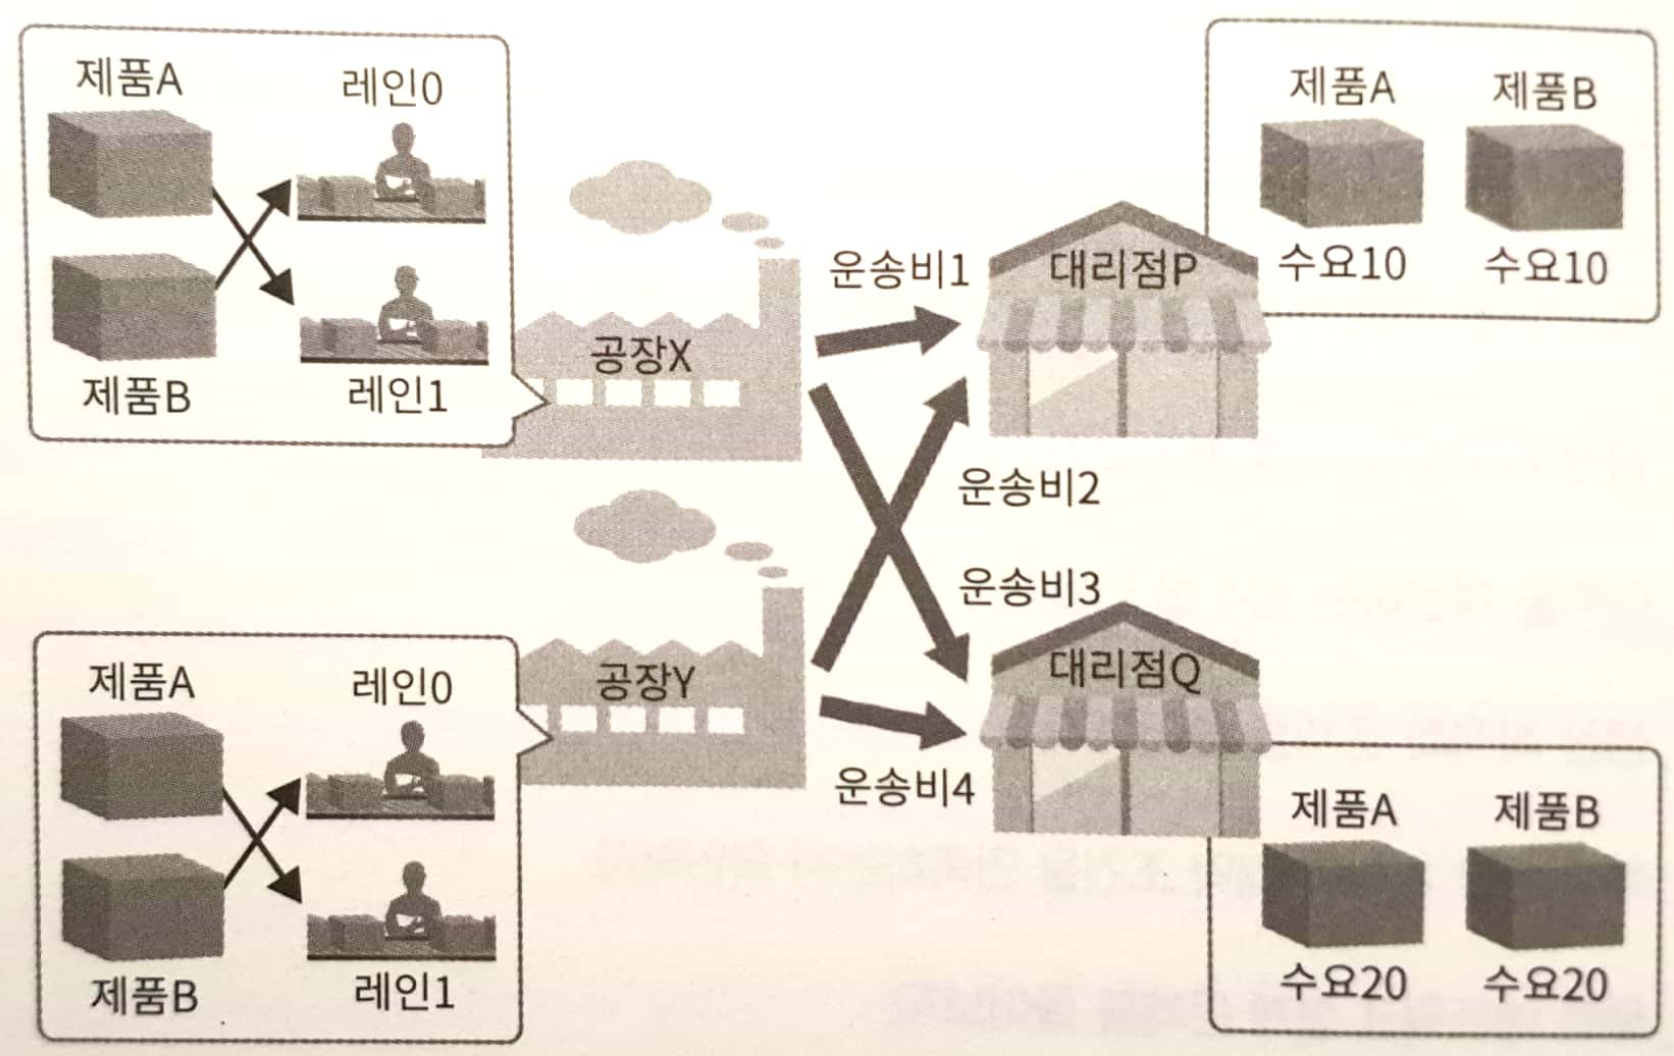

In [3]:
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [4]:
df_tc

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [5]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [7]:
df_supply

,W1,W2,W3
0,35,41,42


In [6]:
# 초기값 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf))); pr

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

In [9]:
# "최소화"를 실행하는 모델 (목적 함수) m1 정의
m1 = model_min()
# 변수 v1 정의: 각 운송 경로 비용에 곱할 변수 정의 (딕셔너리 형태)
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}
v1

{(0, 0): v0_0,
 (0, 1): v0_1,
 (0, 2): v0_2,
 (0, 3): v0_3,
 (1, 0): v1_0,
 (1, 1): v1_1,
 (1, 2): v1_2,
 (1, 3): v1_3,
 (2, 0): v2_0,
 (2, 1): v2_1,
 (2, 2): v2_2,
 (2, 3): v2_3}

In [11]:
# 목적함수 m1을 lpSum을 이용하여 정의 (각 비용과 v1 항목의 곱의 합)
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)

# 제약 조건을 m1에 정의 (창고가 제공할 한계 만족 및 공장이 제조할 제품 수요량 만족)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
    
# 최적화 수행
m1.solve()

# 총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


- 최적화를 수행하면 변수 v1이 최적화된다
- 총 비용이 줄어든 것을 알 수 있다

### 최적운송경로 시각화

In [17]:
# 최적 값
df_tr = df_tr_sol.copy()

In [14]:
df_pos = pd.read_csv('trans_route_pos.csv')
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


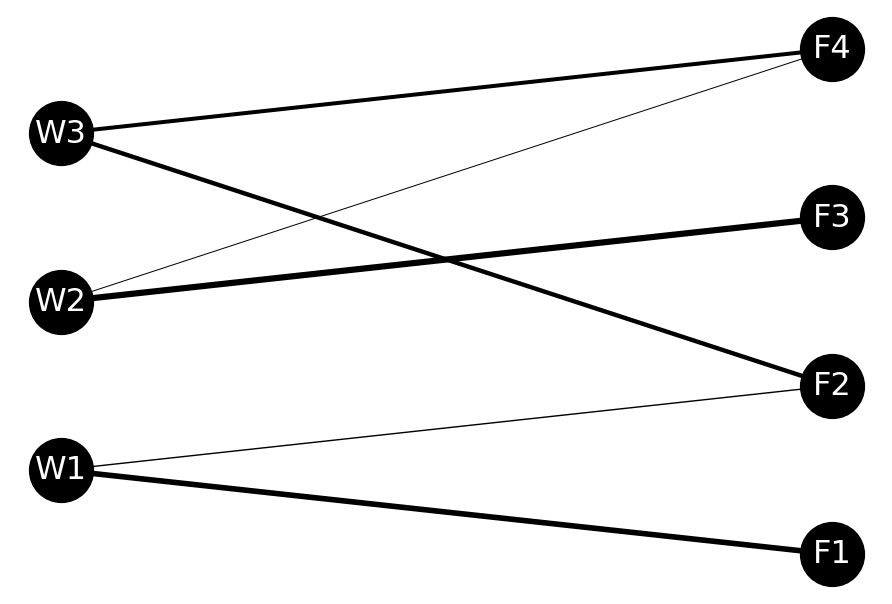

In [15]:
# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                
# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, 
        node_color='k', font_color='w', width=edge_weights)
plt.show()

- w1 -> F1, w2->F3, W3->F2,F4 가 대부분을 차지
- 그 외의 경로는 최소화

### 최적운송경로가 제약조건을 만족하는지 확인

In [21]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


# 생산 최적화
- 앞에서는 운송비용 최적화 수행함
- 생산계획 예시

- 제품 이익 (판매가 - 원가)
- 원료 재고 (현재 재고량)
- 제품 생산량
- 현재 이익이 큰 제품1만 생산하고 있음

In [23]:
!curl https://raw.githubusercontent.com/StillWork/data/master/product.zip\
    -o product.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2250  100  2250    0     0   2922      0 --:--:-- --:--:-- --:--:--     00 --:--:-- --:--:-- --:--:--  2922


In [25]:
!unzip -o product.zip

Archive:  product.zip
  inflating: product_plan_material.csv  
  inflating: __MACOSX/._product_plan_material.csv  
  inflating: product_plan_profit.csv  
  inflating: __MACOSX/._product_plan_profit.csv  
  inflating: product_plan_stock.csv  
  inflating: __MACOSX/._product_plan_stock.csv  
  inflating: product_plan.csv        
  inflating: __MACOSX/._product_plan.csv  


In [27]:
# 제품 제조에 필요한 원료 비율 (제품 1, 2; 원료 1, 2, 3)
df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
df_material

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


In [30]:
# 제품 이익 (제품 가격 - 판매 원가)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
print("----------------")

# 원료 재고량
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
print("----------------")

# 제품 생산량
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

      이익
제품      
제품1  5.0
제품2  4.0
----------------
    원료1  원료2  원료3
항목               
재고   40   80   50
----------------
      생산량
제품       
제품1    16
제품2     0


- 현재 제품1만 생산중임
- 제품2의 생산량을 늘인다면?
- 최적화 문제로 풀어본다 (목적함수 및 제한조건 정의)

### 이익 계산 함수

In [31]:
# 이익 계산 함수 (이익 x 생산량)
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


### 생산 최적화 
- 제품 2를 늘리면?

In [32]:
df = df_material.copy()
inv = df_stock

# 최대화 문제 (수익)
m = model_max()

# 목적 함수 정의 (제품별 이익의 합)
# v1: 제품수와 같은 차원
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

# 제약 조건: 각원료의 사용량이 재고를 넘지 않게
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) 
        ) <= df_stock.iloc[:,i]

m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1  15.0
제품2   5.0
총 이익:95.0


- 제품 2의 생산량을 늘여서 총 이익을 높인 것을 알 수 있다

### 최적생산계획이 제약조건을 만족하는지 확인
- 조건: 각 원료의 사용량 < 재고량 

In [33]:
# 제약 조건 계산 함수
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):  
        temp_sum = 0
        for j in range(len(df_material.index)):  
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1  사용량:25.0, 재고:40.0
원료2  사용량:80.0, 재고:80.0
원료3  사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


- 원료1은 조금 남았다

# 물류네트워크 최적화
- 운송 경로와 생산 계획 최적화를 동시에 고려
- 대리점에서의 수요 예측량을 근거로 각 공장의 생산량을 결정
- 각 제품을 어느 공장의 어느 생산라인 (레인 1, 2)에서 제조할지는 운송 비용 및 제조 비용을 고려하여 결정해야 함
- (방향) 추가 광고나 할인을 하지 않는다면, 비용을 낮추는 기준으로 물류 네트워크를 최적화 한다
- 운송비용과 제조비용이 수요를 만족하면서 최소화 되도록
- (목적함수): 운송비용과 제조비용의 합 (최소화 목표)
- (제약조건): 각 대리점의 판매수가 수요를 넘는 것
- 도구: logistics_network 사용
 - 생산 테이블의 ValY: 최적 생산량이 저장
 - 운송비 테이블의 ValX: 최적 운송량 저장

In [35]:
import numpy as np
import pandas as pd

제품 = list('AB') 
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품), 
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)  # 생산량
print(tbdi2) # 운송비

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


### 최적 네트워크 운송비용과 내역

In [36]:
# 운송비
tbdi2 = tbdi2[["공장","대리점","운송비","제품","VarX","ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000001,10.0
1,X,P,1,B,v000002,10.0
2,X,Q,3,A,v000003,10.0
3,X,Q,3,B,v000004,0.0
4,Y,P,2,A,v000005,0.0
5,Y,P,2,B,v000006,0.0
6,Y,Q,1,A,v000007,10.0
7,Y,Q,1,B,v000008,20.0


- 운송비 x 운송량 = 총 운송 비용

In [37]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

총 운송비:80.0


- 대부분, 운송비가 적은(1) X->P, Y->Q 경로를 이용함
- 대리점 Q의 일부 부족분은 공장 X에서 공급 (10)

### 최적네트워크 생산비용과 내역

In [7]:
# 생산 비용
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000009,20.0
3,X,1,B,0,inf,1.0,v000010,10.0
4,Y,0,A,0,10.0,3.0,v000011,10.0
6,Y,1,A,0,inf,5.0,v000012,0.0
7,Y,1,B,0,inf,3.0,v000013,20.0


In [8]:
# 총 생산 비용
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
print("총 생산비:"+str(product_cost))

총 생산비:120.0


- 가능한 생산 비용이 낮은 X에서 생산 (20, 10)
- 운송비용도 고려하면 Q까지의 운송 비용이 적은 Y에서 일부 생산 (10, 20)
- 즉, 생산비용과 운송 비용의 균형